In [1]:
%pip install  pandas
%pip install fredapi
%pip install xlrd
%pip install pandas_ta
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install scikit-learn
%pip install tensorflow
%pip install --upgrade yfinance==0.2.54
%pip install yfinance





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cf

In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time


### Tickers | Gold, Silver, Copper

In [4]:
tickers = {
    "Gold": "GC=F",
    "Silver": "SI=F",
    "Copper": "HG=F"
}

start_date = "2000-01-01"
end_date = "2024-12-31"

data = {}
for name, ticker in tickers.items():
    print(f"Downloading {name}...")
    df = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    df = df[["Open", "High", "Low", "Close", "Volume"]]
    df.dropna(inplace=True)
    time.sleep(5)

    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD calculation
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    df['MACD'] = macd - signal
    
    # Bollinger Bands
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    df['BB_Width'] = upper_band - lower_band
    
    # Volume Z-score and Percent Change
    df['Volume_Zscore'] = (df['Volume'] - df['Volume'].rolling(30).mean()) / df['Volume'].rolling(30).std()
    df['Pct_Change'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)  # Drop any NaNs from rolling/indicators
    data[name] = df
    df.to_csv(f"{name}_YF_2012_2024.csv")
    print(f" {name} saved with shape: {df.shape}")

# Example output
print("\n🔍 Sample of Gold with features:")
print(data["Gold"].head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


 Gold saved with shape: (6076, 12)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 Silver saved with shape: (6078, 12)


 Copper saved with shape: (6081, 12)

🔍 Sample of Gold with features:
Price             Open        High         Low       Close Volume       SMA_7  \
Ticker            GC=F        GC=F        GC=F        GC=F   GC=F               
Date                                                                            
2000-10-11  272.500000  273.500000  270.500000  270.500000     18  270.685713   
2000-10-12  274.000000  276.399994  274.000000  276.399994      3  271.371425   
2000-10-13  274.200012  274.200012  272.399994  272.399994      0  271.671426   
2000-10-16  271.500000  271.500000  271.500000  271.500000      5  271.799997   
2000-10-17  271.100006  271.100006  271.100006  271.100006      0  272.057142   

Price           SMA_30     RSI_14      MACD  BB_Width Volume_Zscore Pct_Change  
Ticker                                                                          
Date                                                                            
2000-10-11  272.929997  50.431059 -0.2

#### GLD YF

In [5]:
import yfinance as yf
import pandas as pd

# Download GLD data
print(" Downloading GLD...")
gld = yf.download("GLD", start="2000-01-01", end="2024-12-31", interval="1d")

# Keep OHLCV and rename for clarity
gld = gld[["Open", "High", "Low", "Close", "Volume"]].rename(columns={
    "Open": "GLD_Open",
    "High": "GLD_High",
    "Low": "GLD_Low",
    "Close": "GLD_Close",
    "Volume": "GLD_Volume"
})

# Drop any missing values
gld.dropna(inplace=True)

# Save to CSV
gld.to_csv("GLD_2012_2024_OHLCV.csv")

# Preview
print(" Saved to GLD_2012_2024_OHLCV.csv")
print(gld.head())


[*********************100%***********************]  1 of 1 completed

 Saved to GLD_2012_2024_OHLCV.csv
Price        GLD_Open   GLD_High    GLD_Low  GLD_Close GLD_Volume
Ticker            GLD        GLD        GLD        GLD        GLD
Date                                                             
2004-11-18  44.430000  44.490002  44.070000  44.380001    5992000
2004-11-19  44.490002  44.919998  44.470001  44.779999   11655300
2004-11-22  44.750000  44.970001  44.740002  44.950001   11996000
2004-11-23  44.880001  44.919998  44.720001  44.750000    3169200
2004-11-24  44.930000  45.049999  44.790001  45.049999    6105100


In [6]:
# Load the newly uploaded files
gc_df = pd.read_csv("Gold_YF_2012_2024.csv", index_col=0, parse_dates=True)
gld_df = pd.read_csv("GLD_2012_2024_OHLCV.csv", index_col=0, parse_dates=True)

# Merge the datasets on date index
merged_df = gc_df.merge(gld_df, how='left', left_index=True, right_index=True)

# Save the merged result
merged_path = "GCF_GLD.csv"
merged_df.to_csv(merged_path)

# Show confirmation and preview
merged_df.head()


/var/folders/j5/wrgs7dkx0h5ftr4gsr51y6xm0000gn/T/ipykernel_37660/3680640131.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gc_df = pd.read_csv("Gold_YF_2012_2024.csv", index_col=0, parse_dates=True)
/var/folders/j5/wrgs7dkx0h5ftr4gsr51y6xm0000gn/T/ipykernel_37660/3680640131.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gld_df = pd.read_csv("GLD_2012_2024_OHLCV.csv", index_col=0, parse_dates=True)


,Open,High,Low,Close,Volume,SMA_7,SMA_30,RSI_14,MACD,BB_Width,Volume_Zscore,Pct_Change,GLD_Open,GLD_High,GLD_Low,GLD_Close,GLD_Volume
Price,,,,,,,,,,,,,,,,,
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLD,GLD,GLD,GLD,GLD
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-10-11,272.5,273.5,270.5,270.5,18,270.685713,272.929997,50.431059,-0.213476,9.002555,-0.206086,-0.006975,NaN,NaN,NaN,NaN,NaN
2000-10-12,274.0,276.3999938964844,274.0,276.3999938964844,3,271.371425,273.013330,58.333324,0.177530,9.780844,-0.229487,0.021811,NaN,NaN,NaN,NaN,NaN
2000-10-13,274.20001220703125,274.20001220703125,272.3999938964844,272.3999938964844,0,271.671426,272.816664,47.098960,0.162426,9.780995,-0.234134,-0.014472,NaN,NaN,NaN,NaN,NaN


### FRED Api | Macroeconomics indicators

In [8]:
from fredapi import Fred
import pandas as pd
from datetime import datetime

# Initialize with your API key
fred = Fred(api_key='c80af360488242f646f83131680c6c73')  # ← Replace with your actual FRED API key

# Define date range
start_date = '2000-01-01'
end_date = '2024-12-31'

indicators = {
    "CPI": "CPIAUCSL",                      # Consumer Price Index
    "Unemployment_Rate": "UNRATE",         # Civilian Unemployment Rate
    "Fed_Funds_Rate": "FEDFUNDS",          # Effective Federal Funds Rate
    "IPI": "INDPRO",                        # Industrial Production Index
    "M2": "M2SL",                           # Money Stock M2
    "M1": "M1SL",                           # Money Stock M1
    "Consumer_Sentiment": "UMCSENT",       # University of Michigan: Consumer Sentiment
    "1Y_Treasury_Rate": "GS1",             # 1-Year Treasury Constant Maturity Rate
    "Housing_Starts": "HOUST",             # Housing Starts: Total New Privately Owned
    "House_Price_Index": "USSTHPI",        # U.S. All-Transactions House Price Index (quarterly)
    "GDP_Quarterly": "GDPC1",              # Real GDP (Chained 2012 Dollars)
    "Net_Exports_GS":"NETEXP",
    "Balance_Trade": "BOPGSTB",
}


for name, code in indicators.items():
    try:
        data = fred.get_series(code, observation_start=start_date, observation_end=end_date)
        print(f" {name} fetched successfully")
    except Exception as e:
        print(f" {name} ({code}) failed: {e}")
        
        
macro_data = {}
for name, code in indicators.items():
    series = fred.get_series(code, observation_start=start_date, observation_end=end_date)
    df = pd.DataFrame(series, columns=[name])
    df.index.name = "Date"
    macro_data[name] = df

# Combine and resample to daily using forward-fill
macro_combined = pd.concat(macro_data.values(), axis=1)
macro_combined = macro_combined.resample("D").ffill()




 CPI fetched successfully
 Unemployment_Rate fetched successfully
 Fed_Funds_Rate fetched successfully
 IPI fetched successfully
 M2 fetched successfully
 M1 fetched successfully
 Consumer_Sentiment fetched successfully
 1Y_Treasury_Rate fetched successfully
 Housing_Starts fetched successfully
 House_Price_Index fetched successfully
 GDP_Quarterly fetched successfully
 Net_Exports_GS fetched successfully
 Balance_Trade fetched successfully


# CTFC Data 

### 2012-2015

In [75]:

# Load Excel file
cot_12_16_uf = pd.read_excel("raw_data/cot_12-16.xls")

# Filter for selected commodities
selected_commodities = [
    "GOLD - COMMODITY EXCHANGE INC.",
    "COPPER-GRADE #1 - COMMODITY EXCHANGE INC.",
    "SILVER - COMMODITY EXCHANGE INC."
]
cot_12_16_uf = cot_12_16_uf[cot_12_16_uf['Market_and_Exchange_Names'].isin(selected_commodities)]

# Convert the date column to datetime, coercing errors
cot_12_16_uf["As_of_Date_In_Form_YYMMDD"] = pd.to_datetime(
    cot_12_16_uf["As_of_Date_In_Form_YYMMDD"], format="%y%m%d", errors="coerce"
)

# Drop rows where the date conversion failed
cot_12_16_uf = cot_12_16_uf.dropna(subset=["As_of_Date_In_Form_YYMMDD"])

# Filter for data from 2012 to 2016
cot_12_16_uf = cot_12_16_uf[
    (cot_12_16_uf["As_of_Date_In_Form_YYMMDD"] >= "2012-01-01") &
    (cot_12_16_uf["As_of_Date_In_Form_YYMMDD"] <= "2016-12-31")
]

# Keep only the columns you care about
columns_to_keep = [
    "As_of_Date_In_Form_YYMMDD",
    "Market_and_Exchange_Names",
    "M_Money_Positions_Long_ALL",
    "M_Money_Positions_Short_ALL",
    "Open_Interest_All",
    "Tot_Rept_Positions_Long_All",
    "Tot_Rept_Positions_Short_All",
    "Swap_Positions_Long_All",
    "Swap__Positions_Short_All",
    "Change_in_M_Money_Long_All",
    "Change_in_M_Money_Short_All"
]

cot_12_16 = cot_12_16_uf[columns_to_keep]

# Save to CSV
cot_12_16.to_csv("cot_2012_2015.csv", index=False)

# Display first few rows
print(cot_12_16.head())


      As_of_Date_In_Form_YYMMDD         Market_and_Exchange_Names  \
56331                2015-12-29  SILVER - COMMODITY EXCHANGE INC.   
56332                2015-12-22  SILVER - COMMODITY EXCHANGE INC.   
56333                2015-12-15  SILVER - COMMODITY EXCHANGE INC.   
56334                2015-12-08  SILVER - COMMODITY EXCHANGE INC.   
56335                2015-12-01  SILVER - COMMODITY EXCHANGE INC.   

       M_Money_Positions_Long_ALL  M_Money_Positions_Short_ALL  \
56331                       48386                        42104   
56332                       48982                        39643   
56333                       49552                        47917   
56334                       51068                        43127   
56335                       53313                        42866   

       Open_Interest_All  Tot_Rept_Positions_Long_All  \
56331             179819                       154886   
56332             177460                       154269   
56333            

### 2016-2024

In [9]:
import glob

# Define your filters
selected_commodities = [
    "GOLD - COMMODITY EXCHANGE INC.",
    "SILVER - COMMODITY EXCHANGE INC.",
    "COPPER - COMMODITY EXCHANGE INC.",
    "COPPER- #1 - COMMODITY EXCHANGE INC.",
    "COPPER-GRADE #1 - COMMODITY EXCHANGE INC."
]


columns_to_keep = [
    "As_of_Date_In_Form_YYMMDD",
    "Market_and_Exchange_Names",
    "M_Money_Positions_Long_ALL",
    "M_Money_Positions_Short_ALL",
    "Open_Interest_All",
    "Tot_Rept_Positions_Long_All",
    "Tot_Rept_Positions_Short_All",
    "Swap_Positions_Long_All",
    "Swap__Positions_Short_All",
    "Change_in_M_Money_Long_All",
    "Change_in_M_Money_Short_All"
]

# Find all .xls files matching your pattern
file_list = glob.glob("raw_data/c_20*.xls")  # Adjust path if needed

# Container for all data
combined_df = pd.DataFrame()

for file in file_list:
    print(f"Processing: {file}")
    try:
        df = pd.read_excel(file, engine="xlrd")
        
        # Filter for selected commodities
        df = df[df['Market_and_Exchange_Names'].isin(selected_commodities)]
        
        # Convert and clean date
        df['As_of_Date_In_Form_YYMMDD'] = pd.to_datetime(
            df['As_of_Date_In_Form_YYMMDD'], format='%y%m%d', errors='coerce'
        )
        df = df.dropna(subset=['As_of_Date_In_Form_YYMMDD'])

        # Keep only selected columns
        df = df[columns_to_keep]
        
        # Append to master dataframe
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    except Exception as e:
        print(f" Error processing {file}: {e}")

# Save final merged data
combined_df.to_csv("cot_2016_2024.csv", index=False)


### Merge

In [121]:
import pandas as pd

# Load both CSVs
df1 = pd.read_csv("cot_2012_2015.csv")
df2 = pd.read_csv("cot_2016_2024.csv")

# Combine both datasets
cot_2012_2024 = pd.concat([df1, df2], ignore_index=True)

# Convert date column to datetime (if not already)
cot_2012_2024["As_of_Date_In_Form_YYMMDD"] = pd.to_datetime(cot_2012_2024["As_of_Date_In_Form_YYMMDD"])

# Sort by date
cot_2012_2024 = cot_2012_2024.sort_values(by="As_of_Date_In_Form_YYMMDD").reset_index(drop=True)

# Save to a new CSV
cot_2012_2024.to_csv("cot_combined_2012_2024.csv", index=False)

# Preview the result
print(cot_2012_2024.head())


  As_of_Date_In_Form_YYMMDD                  Market_and_Exchange_Names  \
0                2012-01-03           SILVER - COMMODITY EXCHANGE INC.   
1                2012-01-03             GOLD - COMMODITY EXCHANGE INC.   
2                2012-01-03  COPPER-GRADE #1 - COMMODITY EXCHANGE INC.   
3                2012-01-10           SILVER - COMMODITY EXCHANGE INC.   
4                2012-01-10  COPPER-GRADE #1 - COMMODITY EXCHANGE INC.   

   M_Money_Positions_Long_ALL  M_Money_Positions_Short_ALL  Open_Interest_All  \
0                       20325                        10709             142713   
1                      128430                        17836             642722   
2                       22625                        24636             120924   
3                       20043                         8411             139861   
4                       23792                        26257             126766   

   Tot_Rept_Positions_Long_All  Tot_Rept_Positions_Short_All  \
0   

#### Commodity split

In [122]:
import pandas as pd

# Load combined CFTC dataset
cot_df = pd.read_csv("cot_combined_2012_2024.csv", parse_dates=["As_of_Date_In_Form_YYMMDD"])

# Standardize commodity names to simplify downstream merges
cot_df["Market_and_Exchange_Names"] = cot_df["Market_and_Exchange_Names"].replace({
    "GOLD - COMMODITY EXCHANGE INC.": "Gold",
    "SILVER - COMMODITY EXCHANGE INC.": "Silver",
    "COPPER - COMMODITY EXCHANGE INC.": "Copper",
    "COPPER- #1 - COMMODITY EXCHANGE INC.": "Copper",
    "COPPER-GRADE #1 - COMMODITY EXCHANGE INC.": "Copper"
})

# Split into separate DataFrames
cot_gold = cot_df[cot_df["Market_and_Exchange_Names"] == "Gold"].copy()
cot_silver = cot_df[cot_df["Market_and_Exchange_Names"] == "Silver"].copy()
cot_copper = cot_df[cot_df["Market_and_Exchange_Names"] == "Copper"].copy()

# Save each one
cot_gold.to_csv("cot_gold_2012_2024.csv", index=False)
cot_silver.to_csv("cot_silver_2012_2024.csv", index=False)
cot_copper.to_csv("cot_copper_2012_2024.csv", index=False)

# Preview gold
cot_gold.head()


,As_of_Date_In_Form_YYMMDD,Market_and_Exchange_Names,M_Money_Positions_Long_ALL,M_Money_Positions_Short_ALL,Open_Interest_All,Tot_Rept_Positions_Long_All,Tot_Rept_Positions_Short_All,Swap_Positions_Long_All,Swap__Positions_Short_All,Change_in_M_Money_Long_All,Change_in_M_Money_Short_All
1,2012-01-03,Gold,128430,17836,642722,579460,611450,49652,67586,1437.0,2763.0
5,2012-01-10,Gold,126619,16120,644348,579825,614798,44445,70483,-1811.0,-1716.0
8,2012-01-17,Gold,129904,12926,667548,601279,639206,42442,63008,3285.0,-3193.0
9,2012-01-24,Gold,138142,11205,663855,596340,634603,38033,61425,8238.0,-1721.0
13,2012-01-31,Gold,165702,6193,660852,595672,635564,24175,71649,27561.0,-5012.0


#### Merging by Commodity, YF and COT

#### GOLD

##### Shaping the dataframe

In [138]:
# Load the Gold YF file that contains extra rows and unnamed headers
gold_yf = pd.read_csv("Gold_YF_2012_2024.csv", skiprows=2)

# Rename columns properly
gold_yf.columns = [
    "Date", "Open", "High", "Low", "Close", "Volume", "SMA_7", "SMA_30", "RSI_14", 
    "MACD", "BB_Width", "Volume_Zscore", "Pct_Change"
]

# Convert date to datetime and set index
gold_yf["Date"] = pd.to_datetime(gold_yf["Date"])
gold_yf.set_index("Date", inplace=True)

# Save cleaned file
cleaned_yf_path = "gold/Gold_YF_2012_2024_cleaned.csv"
gold_yf.to_csv(cleaned_yf_path)

cleaned_yf_path


'gold/Gold_YF_2012_2024_cleaned.csv'

#### Merge GC=F with COT data

In [157]:
gold_yf = pd.read_csv("gold/Gold_YF_2012_2024_cleaned.csv", parse_dates=["Date"], index_col="Date")

cot_gold = pd.read_csv("cot_gold_2012_2024.csv", parse_dates=["As_of_Date_In_Form_YYMMDD"])
cot_gold.set_index("As_of_Date_In_Form_YYMMDD", inplace=True)
cot_gold.index.name = "Date"

# Merge the two datasets on Date
merged_gold = gold_yf.merge(cot_gold, how="left", left_index=True, right_index=True)

merged_gold = merged_gold.drop(columns=["Market_and_Exchange_Names"]).fillna(method="ffill")

merged_path = "gold/Gold_YF_COT_merged_final.csv"
merged_gold.to_csv(merged_path)


/var/folders/j5/wrgs7dkx0h5ftr4gsr51y6xm0000gn/T/ipykernel_7777/2389388134.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_gold = merged_gold.drop(columns=["Market_and_Exchange_Names"]).fillna(method="ffill")


In [158]:
# Reload the raw GLD CSV and fix header rows before merging
gld_raw = pd.read_csv("GLD_2012_2024_OHLCV.csv", skiprows=2)

gld_raw.columns = ["Date", "GLD_Open", "GLD_High", "GLD_Low", "GLD_Close", "GLD_Volume"]
gld_raw["Date"] = pd.to_datetime(gld_raw["Date"])
gld_raw.set_index("Date", inplace=True)

gold_merged = pd.read_csv("gold/Gold_YF_COT_merged_final.csv", parse_dates=["Date"])
gold_merged.set_index("Date", inplace=True)

final_named_merged = gold_merged.merge(gld_raw, how="left", left_index=True, right_index=True)

# Save final clean output
final_named_path = "gold/Gold_YF_COT_GLD_M.csv"
final_named_merged.to_csv(final_named_path)

final_named_path


'gold/Gold_YF_COT_GLD_M.csv'

#### GC=F,GLD, CoT with forward filling and FRED

##### First month of 2012 is missing vlaues due to release of the macroeconomic indicators in 2011(update quaterly)


In [164]:
# Load your main dataset
gold_df = pd.read_csv("gold/Gold_YF_COT_GLD_M.csv", parse_dates=["Date"])
gold_df.set_index("Date", inplace=True)

# Merge and save
merged = gold_df.merge(macro_combined, how="left", left_index=True, right_index=True)

cols_to_ffill = ['House_Price_Index', 'GDP_Quarterly', 'Net_Exports_GS']
merged[cols_to_ffill] = merged[cols_to_ffill].ffill()

# Check that there are no more missing values in those columns
merged[cols_to_ffill].isnull().sum()

# Save the forward-filled (only) version to a new file
output_path_ffill_only = "gold/Gold_All_M.csv"
merged.to_csv(output_path_ffill_only, index=True)

output_path_ffill_only

'gold/Gold_All_M.csv'

## Silver

#### Merge with SLV

##### Shaping the dataframe

In [ ]:

silver_yf = pd.read_csv("Silver_YF_2012_2024.csv", skiprows=2)

# Rename columns to match structure used in gold
silver_yf.columns = [
    "Date", "Open", "High", "Low", "Close", "Volume", "SMA_7", "SMA_30", "RSI_14", 
    "MACD", "BB_Width", "Volume_Zscore", "Pct_Change"
]

# Convert 'Date' column to datetime and set as index
silver_yf["Date"] = pd.to_datetime(silver_yf["Date"])
silver_yf.set_index("Date", inplace=True)

# Save cleaned Silver dataset
cleaned_silver_path = "silver/Silver_YF_2012_2024_cleaned.csv"
silver_yf.to_csv(cleaned_silver_path)

print(f" Cleaned Silver YF saved at: {cleaned_silver_path}")


#### Merge with COT data

In [ ]:

silver_yf = pd.read_csv("silver/Silver_YF_2012_2024_cleaned.csv", parse_dates=["Date"], index_col="Date")

cot_silver = pd.read_csv("cot_silver_2012_2024.csv", parse_dates=["As_of_Date_In_Form_YYMMDD"])
cot_silver.set_index("As_of_Date_In_Form_YYMMDD", inplace=True)
cot_silver.index.name = "Date"

# 3. Merge on Date
merged_silver = silver_yf.merge(cot_silver, how="left", left_index=True, right_index=True)

# 4. Clean: drop unnecessary column and forward fill missing values
merged_silver = merged_silver.drop(columns=["Market_and_Exchange_Names"]).fillna(method="ffill")

# 5. Save the merged dataset
merged_path = "silver/Silver_YF_COT_merged_final.csv"
merged_silver.to_csv(merged_path)

print(f" Silver + COT merged and saved at {merged_path}")


##### Merge YF, COT with SLV

In [ ]:
slv_raw = yf.download("SLV", start="2012-01-01", end="2024-12-31", interval="1d")
slv_raw = slv_raw[["Open", "High", "Low", "Close", "Volume"]]
slv_raw.reset_index(inplace=True)
slv_raw.columns = ["Date", "SLV_Open", "SLV_High", "SLV_Low", "SLV_Close", "SLV_Volume"]
slv_raw["Date"] = pd.to_datetime(slv_raw["Date"])
slv_raw.set_index("Date", inplace=True)

# Step 2: Load already merged Silver + COT dataset
silver_merged = pd.read_csv("silver/Silver_YF_COT_merged_final.csv", parse_dates=["Date"])
silver_merged.set_index("Date", inplace=True)

# Step 3: Merge SLV into Silver dataset
silver_final = silver_merged.merge(slv_raw, how="left", left_index=True, right_index=True)

# Step 4: Save final file
final_path = "silver/Silver_YF_COT_SLV_M.csv"
silver_final.to_csv(final_path)

print(f" Final Silver dataset with SLV saved at: {final_path}")


#### Merge with FRED

In [ ]:

macro = pd.read_csv("fred_ind/macro_ind_2012_2024.csv", parse_dates=["Date"])
macro.set_index("Date", inplace=True)

# Load your full Silver dataset (Silver + COT + SLV)
silver_df = pd.read_csv("silver/Silver_YF_COT_SLV_M.csv", parse_dates=["Date"])
silver_df.set_index("Date", inplace=True)

# Merge macro indicators
merged = silver_df.merge(macro, how="left", left_index=True, right_index=True)

# Forward-fill slow-moving macro variables
cols_to_ffill = ['House_Price_Index', 'GDP_Quarterly', 'Net_Exports_GS']
merged[cols_to_ffill] = merged[cols_to_ffill].ffill()

# Save final enriched file
output_path = "silver/Silver_All_M.csv"
merged.to_csv(output_path)

print(f" Final Silver dataset saved with macro indicators: {output_path}")


In [ ]:

df = pd.read_csv("silver/Silver_All_M.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# === 1. VWAP ===
df["VWAP"] = (df["High"] + df["Low"] + df["Close"]) / 3

# === 2. COT Ratios ===
df["MM_Long_Ratio"] = df["M_Money_Positions_Long_ALL"] / df["Open_Interest_All"]
df["MM_Short_Ratio"] = df["M_Money_Positions_Short_ALL"] / df["Open_Interest_All"]

df["Dealer_Long_Ratio"] = df["Swap_Positions_Long_All"] / df["Open_Interest_All"]
df["Dealer_Short_Ratio"] = df["Swap__Positions_Short_All"] / df["Open_Interest_All"]


# Lag features
df["Close_lag_1"] = df["Close"].shift(1)
df["Close_lag_3"] = df["Close"].shift(3)
df["Close_lag_7"] = df["Close"].shift(7)

# Moving Averages (on Close)
df["MA_5"] = df["Close"].rolling(window=5).mean()
df["MA_10"] = df["Close"].rolling(window=10).mean()
df["MA_20"] = df["Close"].rolling(window=20).mean()

# Rolling Standard Deviation (volatility)
df["STD_5"] = df["Close"].rolling(window=5).std()
df["STD_10"] = df["Close"].rolling(window=10).std()

# Momentum
df["Pct_Change_1"] = df["Close"].pct_change(1)
df["Pct_Change_3"] = df["Close"].pct_change(3)

# Drop NaNs caused by rolling/lags
df.dropna(inplace=True)


# Save the new dataset
df.to_csv("silver/Silver_All_M1.csv")
print(" Feature engineered dataset saved as 'Silver_All_M_Features.csv'")


## Copper

In [ ]:
import pandas as pd

# Load raw Copper YF file (with extra headers)
copper_yf = pd.read_csv("Copper_YF_2012_2024.csv", skiprows=2)

# Rename columns to match Gold/Silver structure
copper_yf.columns = [
    "Date", "Open", "High", "Low", "Close", "Volume", "SMA_7", "SMA_30", "RSI_14", 
    "MACD", "BB_Width", "Volume_Zscore", "Pct_Change"
]

# Convert Date to datetime and set as index
copper_yf["Date"] = pd.to_datetime(copper_yf["Date"])
copper_yf.set_index("Date", inplace=True)

# Save cleaned Copper dataset
cleaned_copper_path = "copper/Copper_YF_2012_2024_cleaned.csv"
copper_yf.to_csv(cleaned_copper_path)

print(f" Cleaned Copper YF saved at: {cleaned_copper_path}")


In [ ]:

copper_yf = pd.read_csv("copper/Copper_YF_2012_2024_cleaned.csv", parse_dates=["Date"], index_col="Date")

# Step 2: Load Copper COT data
cot_copper = pd.read_csv("cot_copper_2012_2024.csv", parse_dates=["As_of_Date_In_Form_YYMMDD"])
cot_copper.set_index("As_of_Date_In_Form_YYMMDD", inplace=True)
cot_copper.index.name = "Date"

# Step 3: Merge on date and forward-fill COT values
merged_copper = copper_yf.merge(cot_copper, how="left", left_index=True, right_index=True)
merged_copper = merged_copper.drop(columns=["Market_and_Exchange_Names"]).fillna(method="ffill")

# Step 4: Save the merged dataset
merged_copper_path = "copper/Copper_YF_COT_merged_final.csv"
merged_copper.to_csv(merged_copper_path)

print(f" Merged Copper + COT saved at: {merged_copper_path}")


In [ ]:

macro = pd.read_csv("fred_ind/macro_ind_2012_2024.csv", parse_dates=["Date"])
macro.set_index("Date", inplace=True)


# Step 3: Load your Copper + COT merged dataset
copper_df = pd.read_csv("copper/Copper_YF_COT_merged_final.csv", parse_dates=["Date"])
copper_df.set_index("Date", inplace=True)

# Step 4: Merge all macro sources
merged = copper_df.merge(macro, how="left", left_index=True, right_index=True)

# Step 5: Forward-fill slower-moving indicators
cols_to_ffill = ['House_Price_Index', 'GDP_Quarterly', 'Net_Exports_GS']
merged[cols_to_ffill] = merged[cols_to_ffill].ffill()

# Step 6: Save final Copper dataset
final_path = "copper/Copper_All_M.csv"
merged.to_csv(final_path)

print(f" Final Copper dataset saved with FRED: {final_path}")


In [ ]:

copx = yf.download("COPX", start="2012-01-01", end="2024-12-31", interval="1d")

# Step 2: Clean and rename COPX columns
copx = copx[["Open", "High", "Low", "Close", "Volume"]]
copx.reset_index(inplace=True)
copx.columns = ["Date", "COPX_Open", "COPX_High", "COPX_Low", "COPX_Close", "COPX_Volume"]
copx["Date"] = pd.to_datetime(copx["Date"])
copx.set_index("Date", inplace=True)

# Step 3: Load the Copper dataset with all macro + COT merged
copper_df = pd.read_csv("copper/Copper_All_M.csv", parse_dates=["Date"])
copper_df.set_index("Date", inplace=True)

# Step 4: Merge with COPX data
copper_final = copper_df.merge(copx, how="left", left_index=True, right_index=True)

# Step 5: Save final version
final_path = "copper/Copper_All_M.csv"
copper_final.to_csv(final_path)

print(f" Final Copper dataset with COPX saved at: {final_path}")


## After changing the time horizon, First I fetched the whole data again, dropped COT, added SP500, VIX and GPR indicies


### Ending _auto for datasets, targets usage for NeuralForecast libraries. Each of them has additional column with unique_id.


# EDA

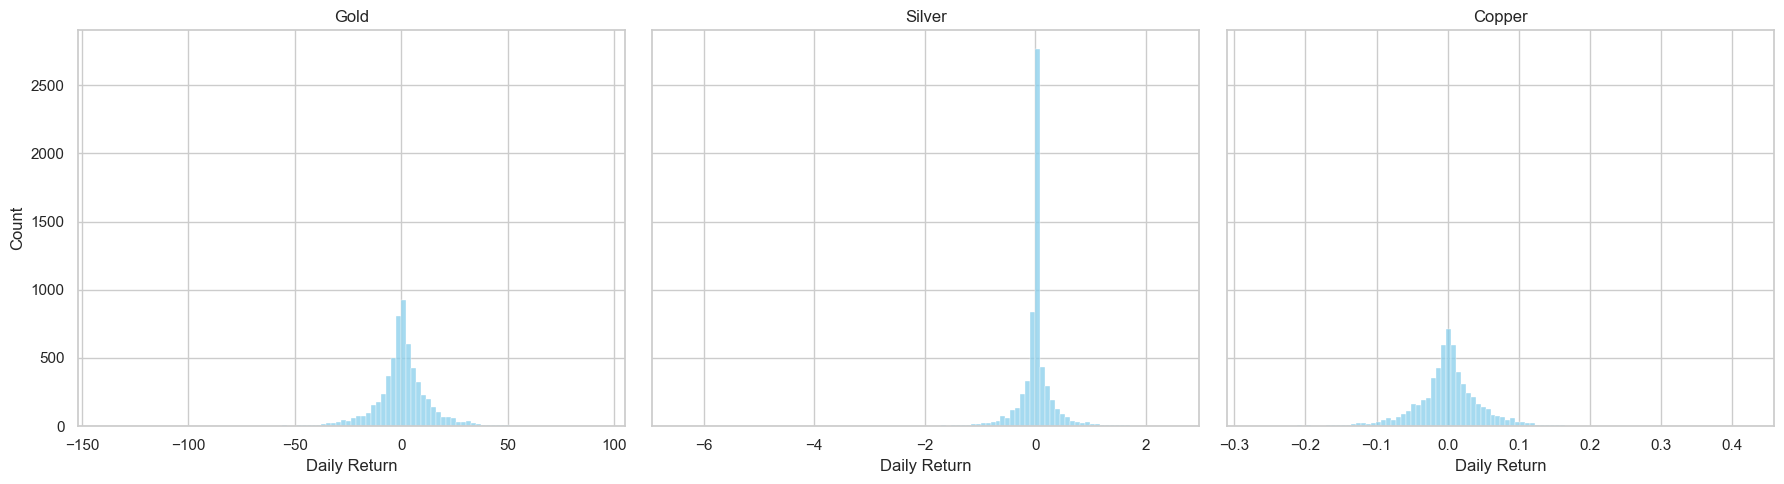

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
gold = pd.read_csv("/Users/x/Desktop/GIt_LFS/Commodities-Forecast-NN/data/gold_fixed_auto.csv")
silver = pd.read_csv("/Users/x/Desktop/GIt_LFS/Commodities-Forecast-NN/data/silver_fixed_auto.csv")
copper = pd.read_csv("/Users/x/Desktop/GIt_LFS/Commodities-Forecast-NN/data/copper_fixed_auto.csv")

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.histplot(gold["y"], bins=100, ax=axes[0], color="skyblue")
axes[0].set_title("Gold")
axes[0].set_xlabel("Daily Return")
axes[0].set_ylabel("Count")

sns.histplot(silver["y"], bins=100, ax=axes[1], color="skyblue")
axes[1].set_title("Silver")
axes[1].set_xlabel("Daily Return")
axes[1].set_ylabel("")

sns.histplot(copper["y"], bins=100, ax=axes[2], color="skyblue")
axes[2].set_title("Copper")
axes[2].set_xlabel("Daily Return")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


In [31]:
summary_stats = pd.DataFrame({
    "Dataset": ["Gold", "Silver", "Copper"],
    "Mean": [gold["y"].mean(), silver["y"].mean(), copper["y"].mean()],
    "Standard Deviation": [gold["y"].std(), silver["y"].std(), copper["y"].std()]
})


In [32]:
summary_stats.set_index('Dataset', inplace=True)

print("\nTarget Variable Summary Statistics:\n")
print(summary_stats.round(6))


Target Variable Summary Statistics:

             Mean  Standard Deviation
Dataset                              
Gold     0.383407           13.590070
Silver   0.005431            0.373605
Copper   0.000545            0.048701


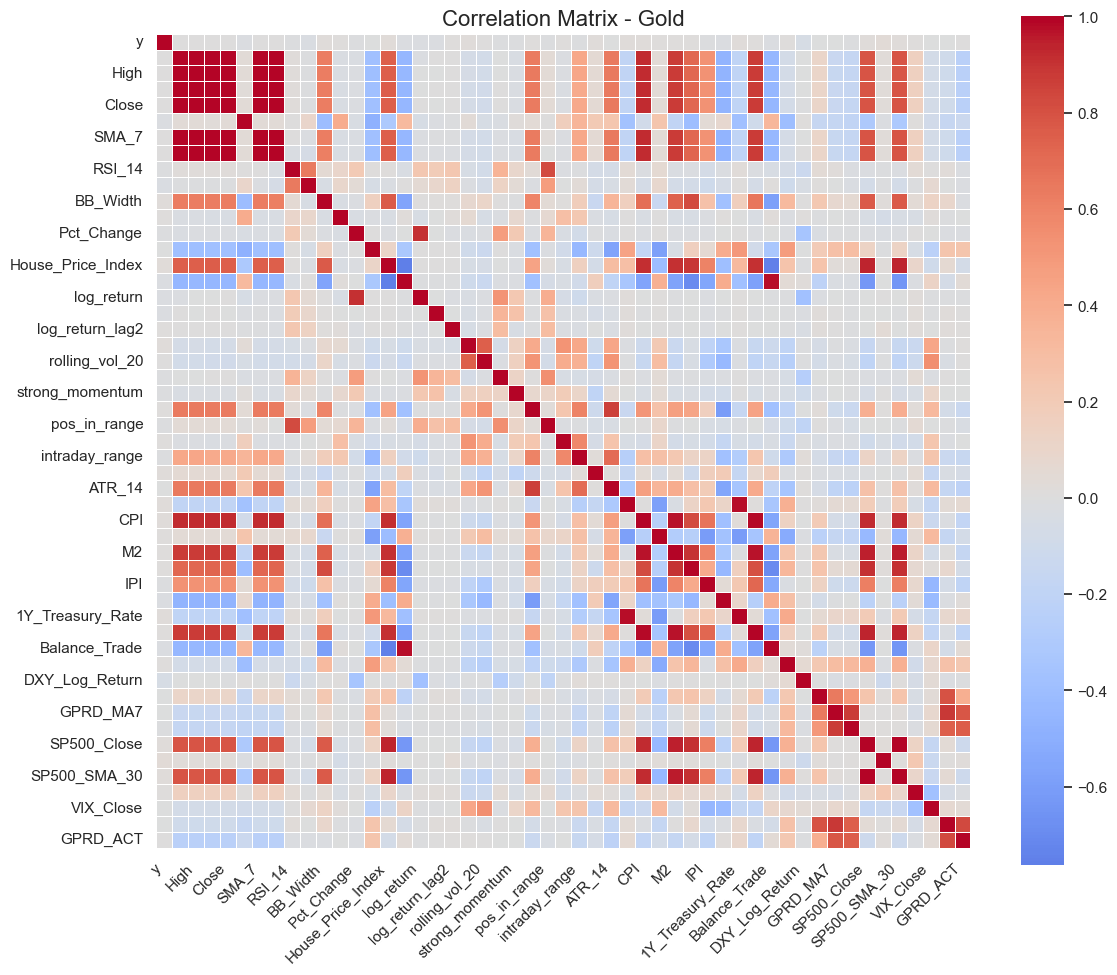

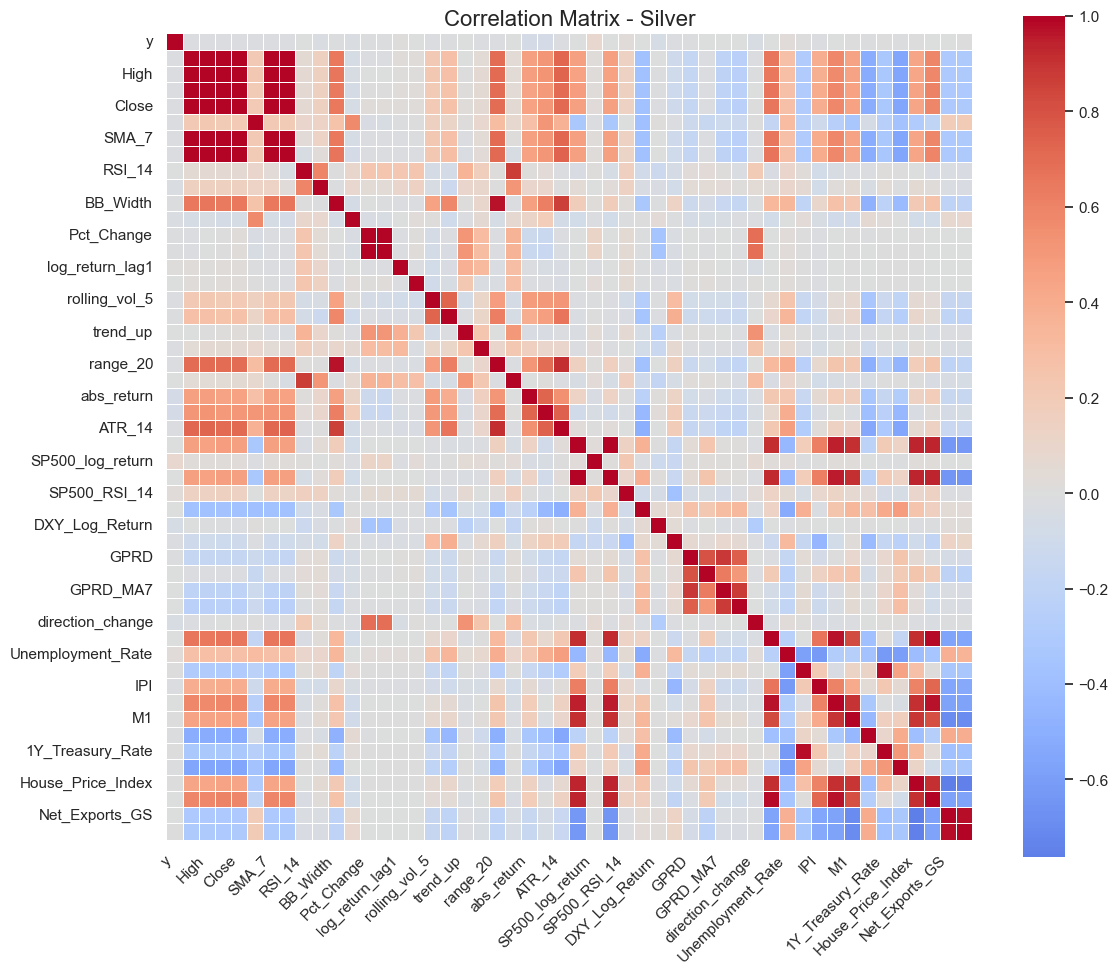

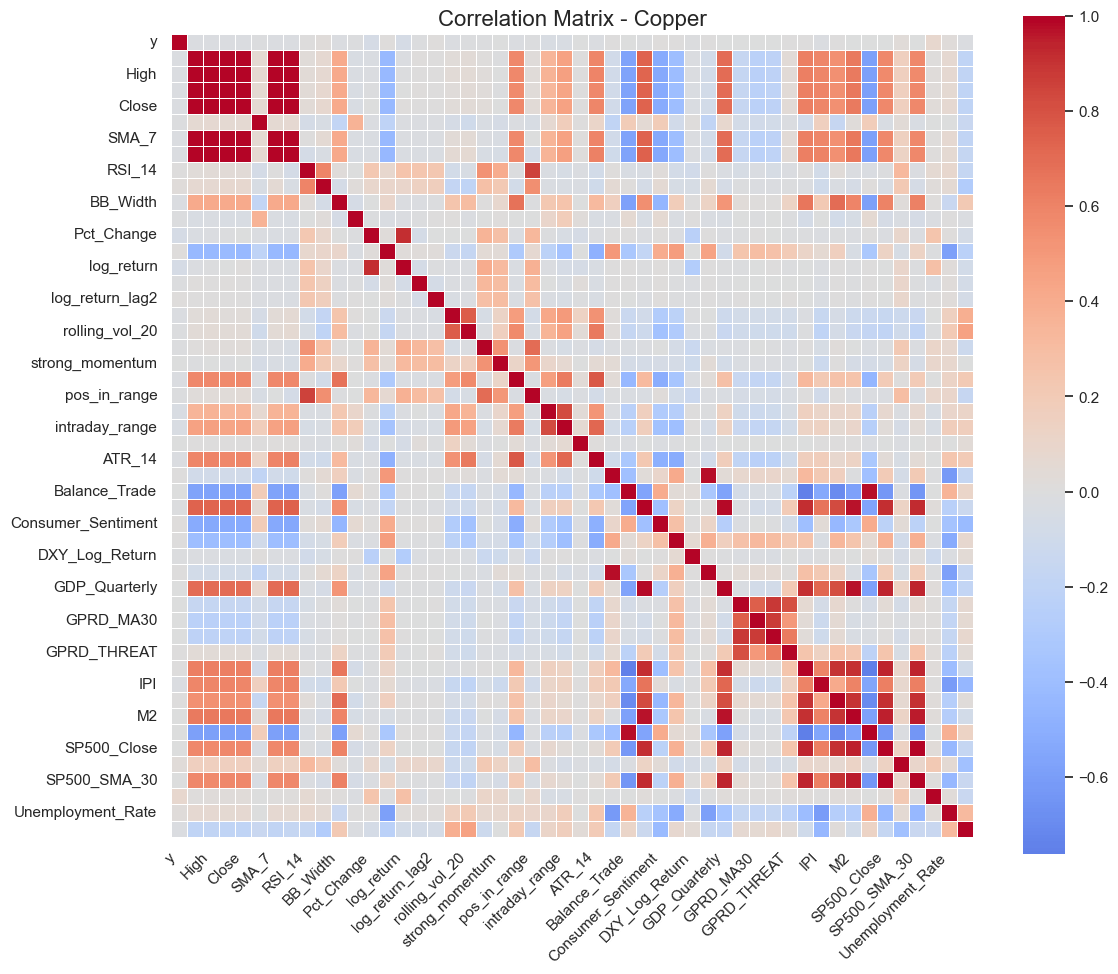

In [33]:
gold_corr = gold.select_dtypes(include='number').corr()
silver_corr = silver.select_dtypes(include='number').corr()
copper_corr = copper.select_dtypes(include='number').corr()

# Plotting function
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, square=True, linewidths=.5)
    plt.title(f'Correlation Matrix - {title}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot each
plot_corr_matrix(gold_corr, "Gold")
plot_corr_matrix(silver_corr, "Silver")
plot_corr_matrix(copper_corr, "Copper")

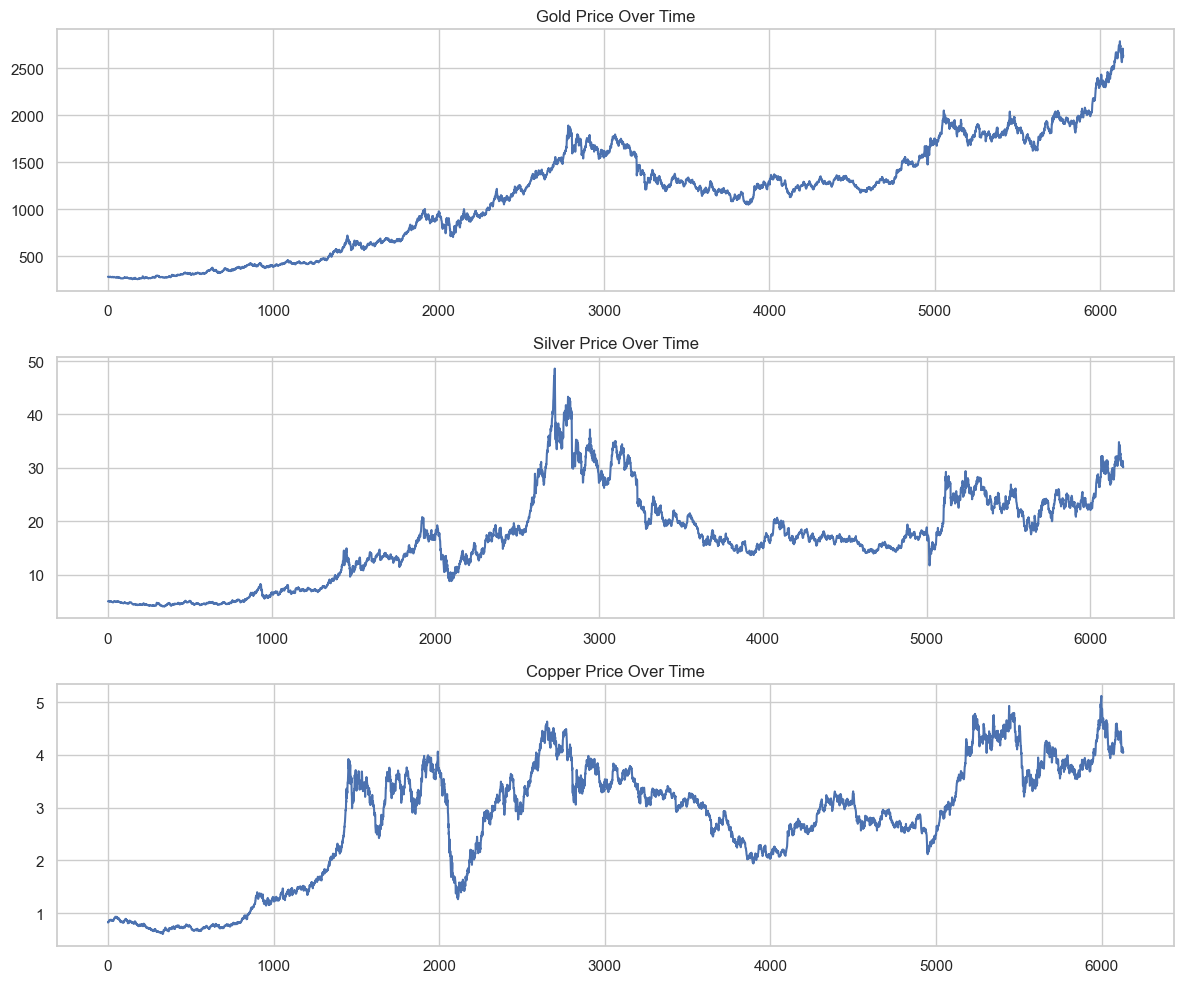

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
gold['Close'].plot()
plt.title('Gold Price Over Time')

plt.subplot(3, 1, 2)
silver['Close'].plot()
plt.title('Silver Price Over Time')

plt.subplot(3, 1, 3)
copper['Close'].plot()
plt.title('Copper Price Over Time')

plt.tight_layout()
plt.show()


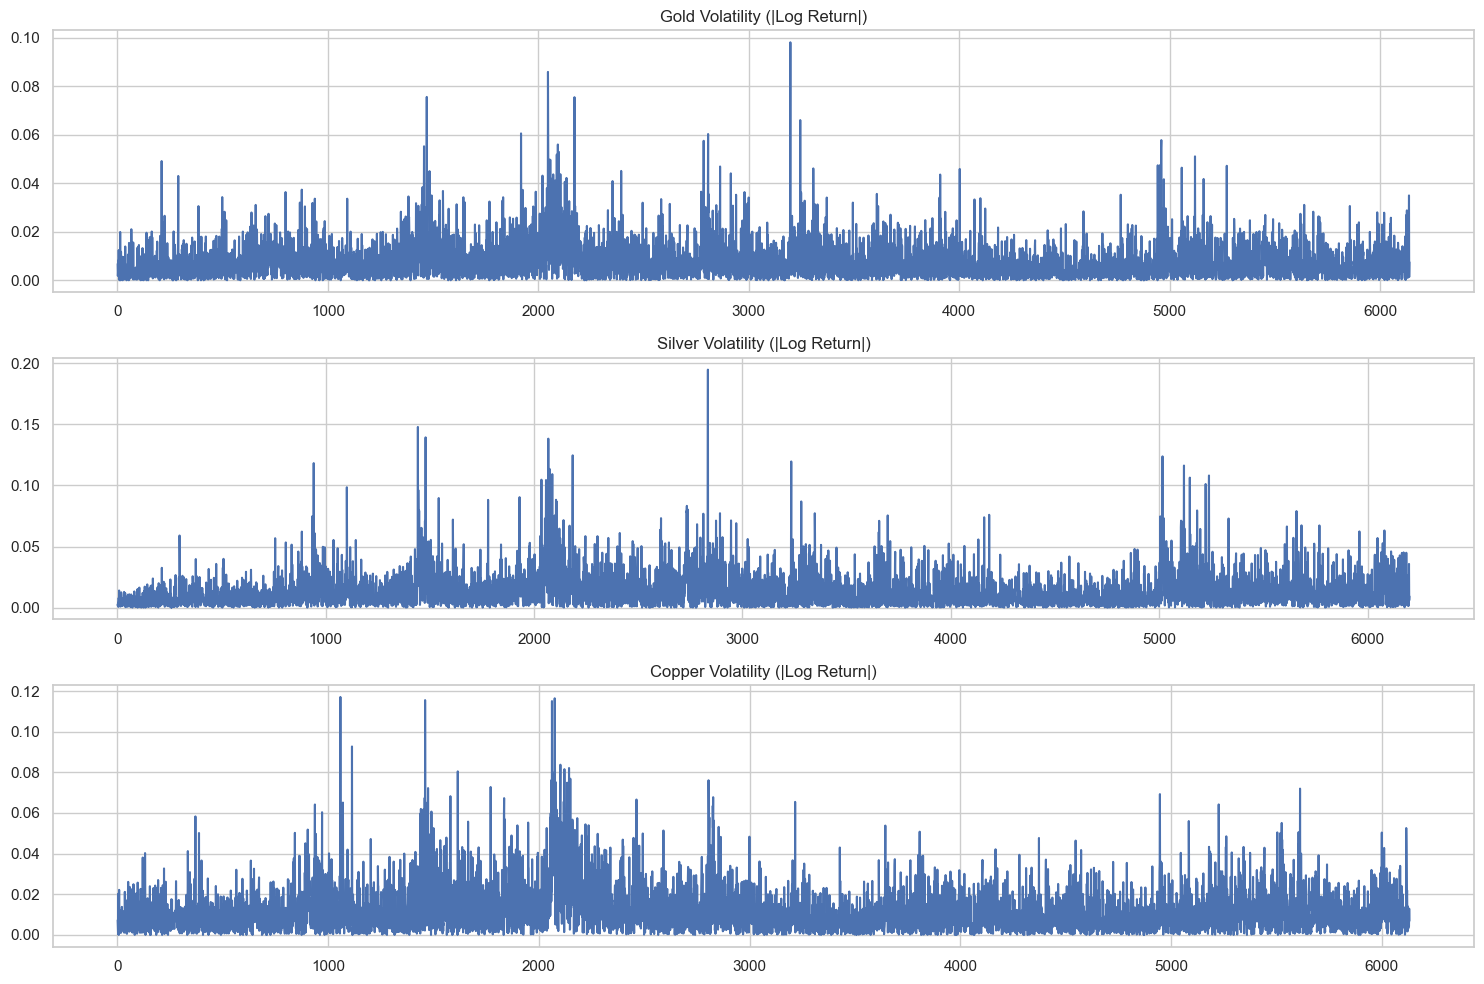

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute log returns
gold['abs_return'] = np.abs(np.log(gold['Close'] / gold['Close'].shift(1)))
silver['abs_return'] = np.abs(np.log(silver['Close'] / silver['Close'].shift(1)))
copper['abs_return'] = np.abs(np.log(copper['Close'] / copper['Close'].shift(1)))

# Plot
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(gold['abs_return'])
plt.title('Gold Volatility (|Log Return|)')

plt.subplot(3, 1, 2)
plt.plot(silver['abs_return'])
plt.title('Silver Volatility (|Log Return|)')

plt.subplot(3, 1, 3)
plt.plot(copper['abs_return'])
plt.title('Copper Volatility (|Log Return|)')

plt.tight_layout()
plt.show()


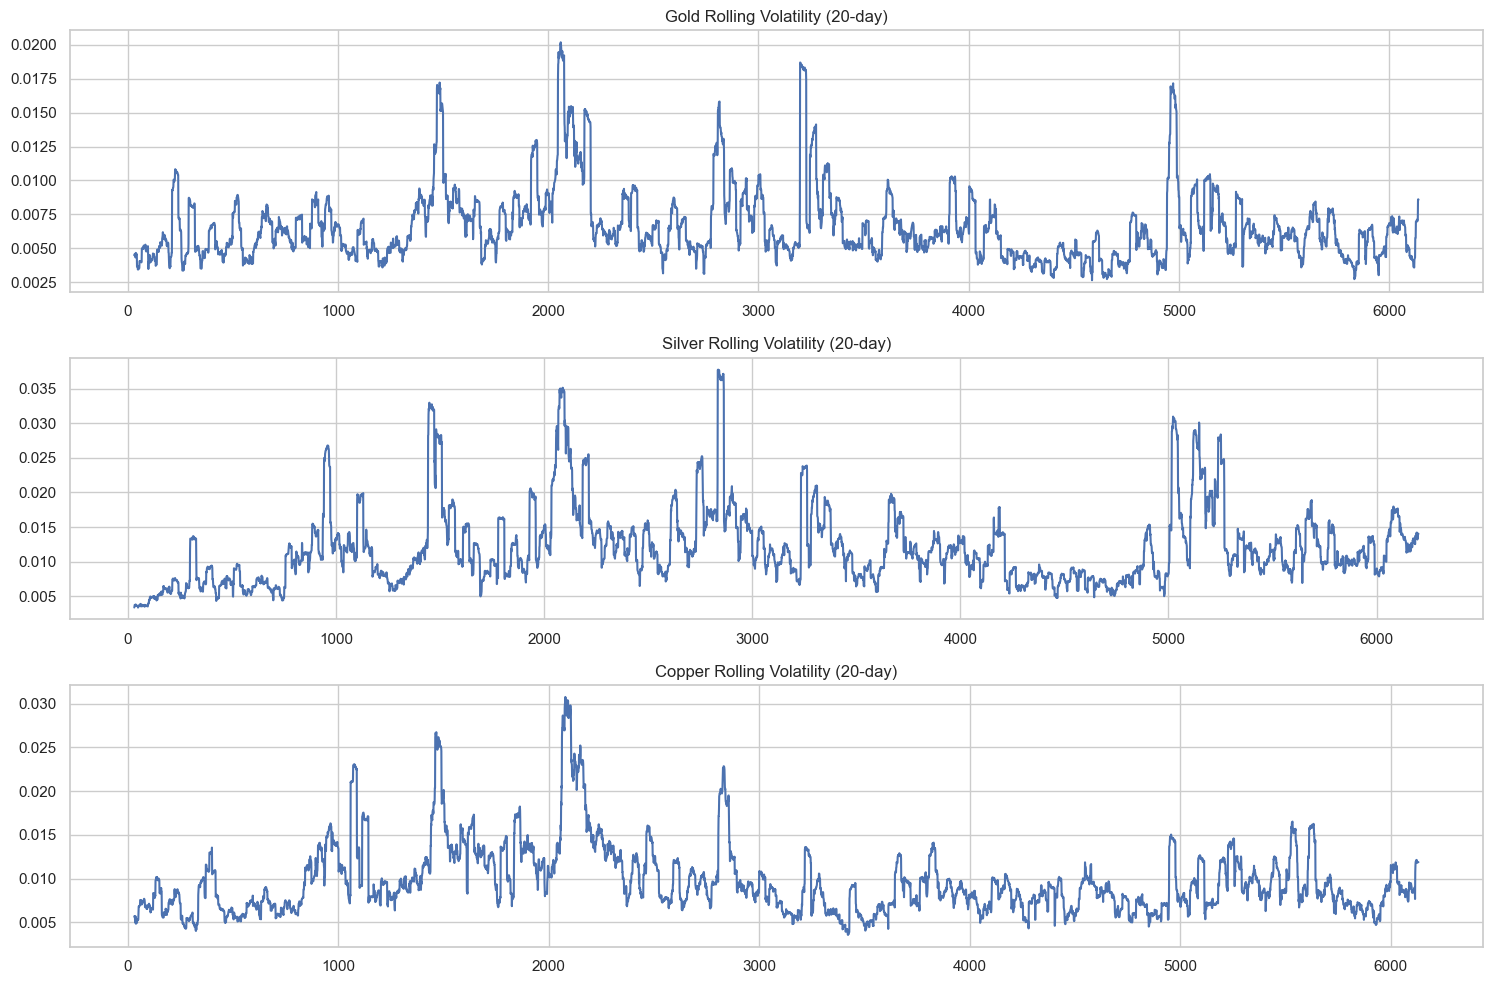

In [42]:
window = 30  

gold['volatility'] = gold['abs_return'].rolling(window=window).std()
silver['volatility'] = silver['abs_return'].rolling(window=window).std()
copper['volatility'] = copper['abs_return'].rolling(window=window).std()

# Plot
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(gold['volatility'])
plt.title('Gold Rolling Volatility (20-day)')

plt.subplot(3, 1, 2)
plt.plot(silver['volatility'])
plt.title('Silver Rolling Volatility (20-day)')

plt.subplot(3, 1, 3)
plt.plot(copper['volatility'])
plt.title('Copper Rolling Volatility (20-day)')

plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

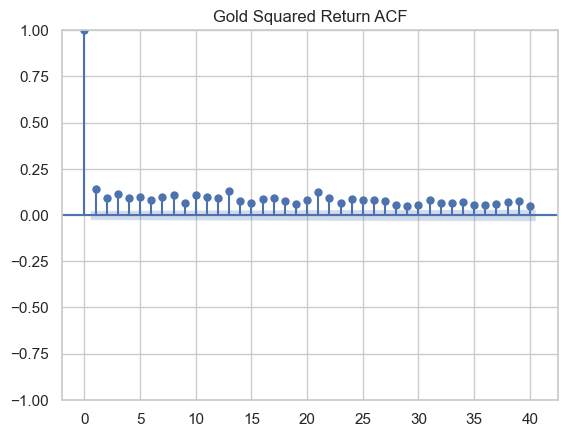

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 8))
plot_acf(gold['abs_return'].dropna()**2, lags=40, title='Gold Squared Return ACF')
plt.show()
